**Table of contents**<a id='toc0_'></a>    
- [Loading the data](#toc1_1_1_1_)    
- [Overview of Cable Roads](#toc1_1_1_2_)    
- [Single CR with Relief](#toc1_1_1_3_)    
- [The Influence of Pulling Force on Slope](#toc1_1_1_4_)    
- [Forces on Anchor Tree and Tower Change According to Force and Angle](#toc1_1_1_5_)    
- [Resulting Force on Support per Angle and Incoming Force](#toc1_1_1_6_)    
- [Surface Plots of Mechanical Functions](#toc1_1_1_7_)    
- [Experimental Code Execution Visualization](#toc1_1_1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

#### <a id='toc1_1_1_1_'></a>[Loading the data](#toc0_)

In [8]:
# Package Imports
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

from importlib import reload

from ipywidgets import interact, IntSlider

import plotly.graph_objects as go
import plotly.express as px
from plotly_gif import GIF, capture

%matplotlib widget

# Importing my modules
from src.main import plotting, geometry_operations, geometry_utilities, cable_road_computation, mechanical_computations, classes
from src.tests import helper_functions

In [29]:
line_gdf, tree_gdf, height_gdf = helper_functions.set_up_gdfs()

In [30]:
line_gdf_full_small = line_gdf.iloc[::10]
height_gdf_small = height_gdf.iloc[::100]

#### <a id='toc1_1_1_2_'></a>[Overview of Cable Roads](#toc0_)

In [33]:
reload(classes)
this_cable_road = classes.load_cable_road(line_gdf, 2)
this_cable_road.count_segments()

0

In [12]:
reload(classes)
reload(plotting)
fig = px.scatter_3d(x=height_gdf_small["x"], y=height_gdf_small["y"], z=height_gdf_small["elev"])
fig.update_traces(marker={'size': 0.75})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), width=1000,height=800, title="Relief Map with possible Cable Roads")

for index in range(len(line_gdf)-1):
    this_cable_road = classes.load_cable_road(line_gdf, index)
    plotting.plot_cr_relief(this_cable_road, line_gdf, height_gdf, index, fig, show_straight_line=False)

fig.show("notebook_connected")

KeyboardInterrupt: 

In [23]:
# fig.write_html("02_Figures/All_Cable_Roads_with_Relief.html")
fig.update_layout(
    width=2000,)
fig.show("notebook_connected")

#### <a id='toc1_1_1_3_'></a>[Single CR with Relief](#toc0_)

In [13]:
reload(mechanical_computations)
reload(classes)
reload(plotting)
# Setting up a sample cable road
index = 1
force = 60000
sample_line = line_gdf_full.iloc[index].geometry
sample_cable_road = classes.Cable_Road(sample_line, height_gdf, force)
plotting.plot_cr_relief(sample_cable_road, line_gdf_full,height_gdf, index)

Cable road created from line:  (-28.09774993774453, -7.853619242961038) to  (-96.73072895, 98.53306229)
Cable road created from line:  (-15.12792573, -26.16056076) to  (-28.09774993774453, -7.853619242961038)
Cable road created from line:  (5.750624681, -23.50333184) to  (-28.09774993774453, -7.853619242961038)
Cable road created from line:  (-22.92090482, -30.73934474) to  (-28.09774993774453, -7.853619242961038)


In [37]:
reload(mechanical_computations)
reload(classes)
reload(plotting)
# Setting up a sample cable road
index = 0
force = 60000
sample_line = line_gdf_full.iloc[index].geometry
sample_cable_road = classes.Cable_Road(sample_line, height_gdf, force)
plotting.plot_cr_relief(sample_cable_road, line_gdf_full,height_gdf, index, show_straight_line=True)

Cable road created from line:  (-29.880646898378075, -8.757599103801436) to  (-106.0132132, 89.40781657)
Cable road created from line:  (-15.12792573, -26.16056076) to  (-29.880646898378075, -8.757599103801436)
Cable road created from line:  (5.750624681, -23.50333184) to  (-29.880646898378075, -8.757599103801436)
Cable road created from line:  (-22.92090482, -30.73934474) to  (-29.880646898378075, -8.757599103801436)
Cable road created from line:  (-29.880646898378075, -8.757599103801436) to  (-83.54479257, 57.81202571)
Cable road created from line:  (-83.54479257, 57.81202571) to  (-106.0132132, 89.40781657)


In [35]:
sample_cable_road.line_to_floor_distances- sample_cable_road.sloped_line_to_floor_distances

array([0.        , 0.19610548, 0.38910472, 0.57899767, 0.76578444,
       0.94946492, 1.1300391 , 1.30750704, 1.48186886, 1.65312433,
       1.82127357, 1.98631644, 2.1482532 , 2.30708361, 2.46280789,
       2.61542583, 2.76493764, 2.9113431 , 3.0546422 , 3.19483519,
       3.33192182, 3.46590233, 3.59677649, 3.72454453, 3.84920621,
       3.97076178, 4.08921099, 4.20455408, 4.31679058, 4.42592096,
       4.53194523, 4.63486338, 4.73467493, 4.83138037, 4.92497969,
       5.01547241, 5.10285902, 5.18713951, 5.26831388, 5.34638166,
       5.42134333, 5.49319887, 5.56194782, 5.62759113, 5.69012785,
       5.74955797, 5.80588245, 5.85910034, 5.90921211, 5.95621729,
       6.00011635, 6.04090929, 6.07859612, 6.11317635, 6.14465094,
       6.17301846, 6.19828033, 6.22043562, 6.23948479, 6.25542784,
       6.26826429, 6.27799511, 6.28461885, 6.28813696, 6.28854847,
       6.28585386, 6.28005314, 6.2711463 , 6.25913286, 6.24401331,
       6.22578716, 6.20445538, 6.18001699, 6.1524725 , 6.12182

#### <a id='toc1_1_1_4_'></a>[The Influence of Pulling Force on Slope](#toc0_)

In [16]:
from plotly.subplots import make_subplots


# xmin, xmax, nx = 0.0, 100.0, 57
# x = np.linspace(xmin, xmax, nx)

force = 50000
# Setting up a sample cable road
index = 3
sample_line = line_gdf.iloc[index].geometry
sample_cable_road = classes.Cable_Road(sample_line, height_gdf, force)
y = sample_cable_road.sloped_line_to_floor_distances

fig = go.FigureWidget(make_subplots(rows=1, cols=2))
sloped_ltfd = fig.add_scatter(x=x,
                      y=y, name="Distance to Floor")

sloped_ltfd_pestal = fig.add_scatter(x=x,
                      y=y, name="Pestal Load Path")


fig.update_layout(title='Cable Road Slope',
                    xaxis_title='Width in Meters',
                    yaxis_title='Height in Meters',
                    yaxis=dict(range=[-50, 50]),
                    xaxis=dict(range=[-10,110]),
                    width=1200,height=800)

gif = GIF()

@capture(gif)
@interact(force=(0, 200000, 1000))
def update(force=force):
    sample_cable_road.s_current_tension = force
    sample_cable_road.compute_loaded_unloaded_line_height()
    y = sample_cable_road.sloped_line_to_floor_distances
    fig.data[0].y = y
    fig.show()
    # return fig

# fig.write_html("02_Figures/Cable_Road_Slope.html")
fig.show("notebook_connected")

initialize_line_tension


interactive(children=(IntSlider(value=50000, description='force', max=200000, step=1000), Output()), _dom_clas…

In [ ]:
# n = 10000
# r1 = range(0, n, 100)
# r2 = range(n, 0, -100)
# for i in [*r1, *r2]:
#     # Changes the range of the data each step to make it look like a time series
#     update(i)

# # Create gif
# gif.create_gif()

In [ ]:
# display(Image(data=open("02_Figures/Cable_Road_Slope.gif",'rb').read(), format='png'))

#### <a id='toc1_1_1_5_'></a>[Forces on Anchor Tree and Tower Change According to Force and Angle](#toc0_)

In [28]:
sample_cable_road.s_current_tension

65000

In [29]:
reload(mechanical_computations)
index = 0
sample_cable_road = classes.set_up_CR_from_linegdf(line_gdf_full, index, height_gdf)

mechanical_computations.check_if_tower_and_anchor_trees_hold(sample_cable_road, line_gdf_full.iloc[index].max_holding_force, line_gdf_full.iloc[index].possible_anchor_triples, height_gdf)

Cable road created from line:  (-29.880646898378075, -8.757599103801436) to  (-106.0132132, 89.40781657)
checking if tower and anchor trees hold
force on anchor 46999.99999999999 force on twoer 221253.1810765148 max supported force by anchor 50455.810418596404
found anchor tree that holds


True

In [ ]:
mechanical_computations.check_if_support_withstands_tension

interactive(children=(IntSlider(value=2, description='index', max=54), IntSlider(value=50000, description='for…

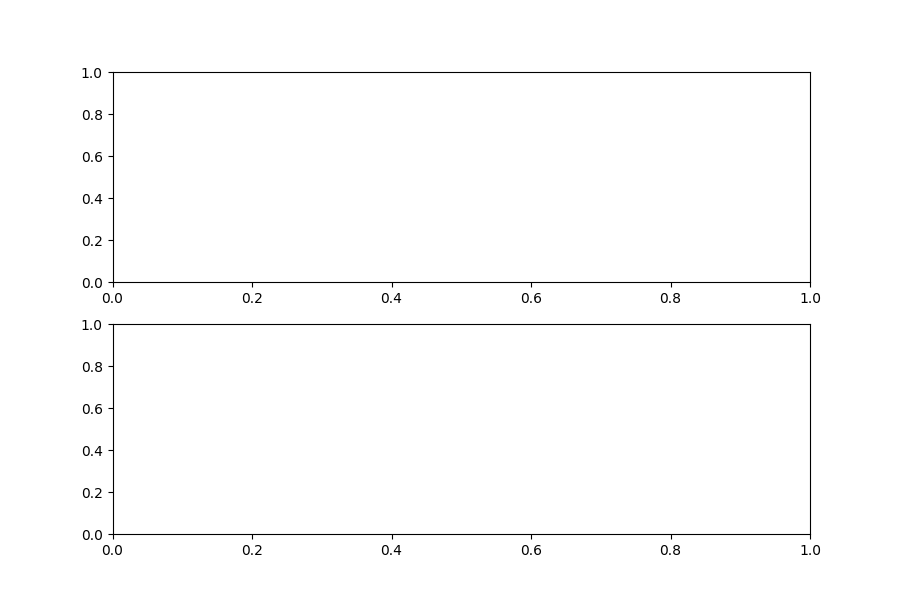

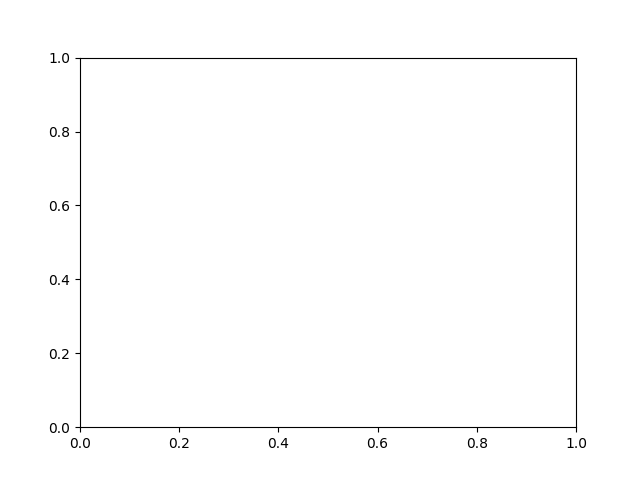

In [24]:
# Checking the anchor trees
reload(mechanical_computations)
reload(geometry_operations)
reload(plotting)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6)) # two rows, one column
fig, ax3 = plt.subplots()
index = 1

def plot_anchors_hold(index, force):
    plt.cla()
    sample_cable_road = classes.set_up_CR_from_linegdf(line_gdf_full, index, height_gdf)
    sample_cable_road.s_current_tension = force
    mechanical_computations.check_if_tower_and_anchor_trees_hold(sample_cable_road,line_gdf_full.iloc[index].max_holding_force, line_gdf_full.iloc[index].possible_anchor_triples, height_gdf, ax, ax2, ax3)
    fig.canvas.draw()
    
interact(plot_anchors_hold, index=IntSlider(min=0, max=len(line_gdf_full), step=1, value=2), force=IntSlider(min=50000, max=100000, step=1000, value=1000));

checking if tower and anchor trees hold
force on anchor 44000.000000000015 force on twoer 203892.47796678517 max supported force by anchor 54142.47444834902
force on anchor 43000.00000000002 force on twoer 202585.9324313351 max supported force by anchor 40398.26654467902
force on anchor 43000.0 force on twoer 202253.8590462774 max supported force by anchor 39010.83535389991
did not find anchor tree that holds - final


False

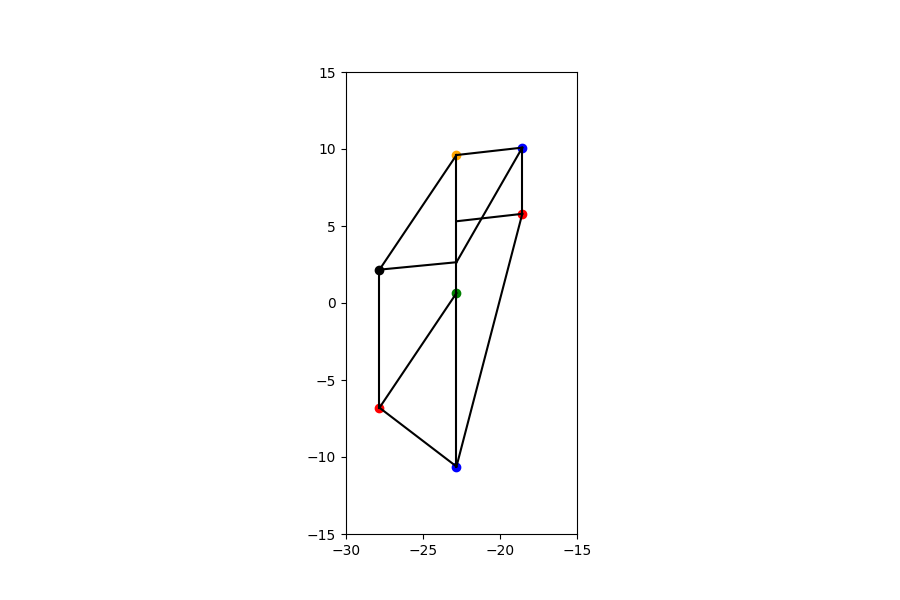

In [67]:
reload(mechanical_computations)
reload(plotting)
fig, ( ax3) = plt.subplots(1, 1, figsize=(9, 6)) # two rows, one column
mechanical_computations.check_if_tower_and_anchor_trees_hold(sample_cable_road,line_gdf_full.iloc[index].max_holding_force, line_gdf_full.iloc[index].possible_anchor_triples, height_gdf, ax=ax, ax2=ax2, ax3=ax3)

In [34]:
mechanical_computations.check_if_tower_and_anchor_trees_hold(left_cr, line_gdf_full.iloc[index].max_holding_force, line_gdf_full.iloc[index].possible_anchor_triples, height_gdf)

checking if tower and anchor trees hold
force on anchor 47999.99999999998 force on twoer 220681.71664553013 max supported force by anchor 50455.810418596404
found anchor tree that holds


True

Cable road created from line:  (-29.880646898378075, -8.757599103801436) to  (-83.54479257, 57.81202571)
Cable road created from line:  (-83.54479257, 57.81202571) to  (-106.0132132, 89.40781657)
checking if support withstands tension
computing tension loaded vs unloaded cable road
Angle: 9.187487423183228
Force on loaded cable: 10411.71075654691
computing tension loaded vs unloaded cable road
Angle: 8.630769750923463
Force on loaded cable: 9782.043051709616
forces on lr support 10411.71075654691 9782.043051709616


True

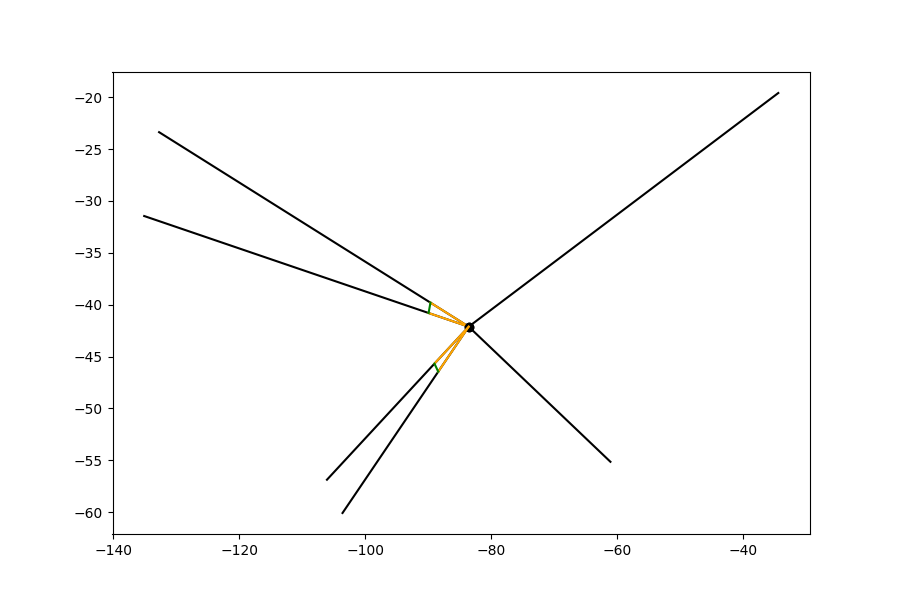

In [33]:
reload(mechanical_computations)

index = 0
left_line = LineString([Point(line_gdf_full.iloc[index].geometry.coords[0]), line_gdf_full.iloc[index].location_of_int_supports[0]])
left_cr = classes.Cable_Road(left_line,height_gdf, pre_tension=line_gdf_full.iloc[index].current_tension)

right_line = LineString([line_gdf_full.iloc[index].location_of_int_supports[0], Point(line_gdf_full.iloc[index].geometry.coords[1])])
right_cr = classes.Cable_Road(right_line,height_gdf, pre_tension=line_gdf_full.iloc[index].current_tension)

mechanical_computations.check_if_support_withstands_tension(100000,left_cr, right_cr)

#### <a id='toc1_1_1_6_'></a>[Resulting Force on Support per Angle and Incoming Force](#toc0_)

In [ ]:
unloaded_tangent_line_x = [0, 100000]
unloaded_tangent_line_y = [0, 0]
loaded_tangent_line_x = [0, 100000]
loaded_tangent_line_y = [0, 0]
force_on_support_x = [0, 0]
force_on_support_y = [0, 0]

fig = go.FigureWidget()
bar = fig.add_scatter(x=[*unloaded_tangent_line_x,*loaded_tangent_line_x,*force_on_support_x],
                      y=[*unloaded_tangent_line_y,*loaded_tangent_line_y,*force_on_support_y])

bar.update_layout(title='Resulting Force per Angle',xaxis_title='Force Vector on Support',
                    yaxis_title='Force Vector on Cable',
                    yaxis=dict(range=[-100000, 10]),
                    xaxis=dict(range=[-10,100000]))

gif = GIF()

@capture(gif)
@interact(force=(0, 100000, 1000), angle=(0, 50, 1))
def update(force=10000, angle=30):
    res = mechanical_computations.parallelverschiebung(force, angle)
    loaded_tangent_line_y=[0, -res]
    loaded_tangent_line_x=[0, force]
    force_on_support_x = [0, 0]
    force_on_support_y = [0, -res]
    fig.data[0].x=[*unloaded_tangent_line_x,*loaded_tangent_line_x,*force_on_support_x]
    fig.data[0].y=[*unloaded_tangent_line_y,*loaded_tangent_line_y,*force_on_support_y]
    fig.show()
    # return fig

# fig.write_html("Resulting_Force_per_Angle.html",full_html=True)
fig.show("notebook_connected")

interactive(children=(IntSlider(value=10000, description='force', max=100000, step=1000), IntSlider(value=30, …

In [81]:
# n = 10000
# r1 = range(0, n, 100)
# r2 = range(n, 0, -100)
# for i in [*r1, *r2]:
#     # Changes the range of the data each step to make it look like a time series
#     update(i)

# # Create gif
# gif.create_gif()

In [79]:
# display(Image(data=open("02_Figures/Resulting_Force_Parallelverschiebung.gif",'rb').read(), format='png'))

#### <a id='toc1_1_1_7_'></a>[Surface Plots of Mechanical Functions](#toc0_)

In [40]:
mechanical_computations.euler_knicklast(8,14)

16.199197612564802

In [41]:
import plotly.graph_objects as go
reload(mechanical_computations)

x = np.arange(10,60,1)
y = np.arange(5,30,1)
X, Y = np.meshgrid(x, y)
Z = mechanical_computations.euler_knicklast(X,Y)

fig = go.Figure(data=[go.Surface(z=Z)])

fig.update_layout(scene = dict(
                    xaxis_title='Tree Diameter in Meters',
                    yaxis_title='Height of Attachment in Meters',
                    zaxis_title='Maximum Force in Newton'),
                    width=900,height=900)
# fig.write_html("02_Figures/Resulting Force Knicklast.html")
fig.show("notebook_connected")

#### <a id='toc1_1_1_8_'></a>[Experimental Code Execution Visualization](#toc0_)

In [67]:
import plotly.graph_objects as go
import inspect

def create_call_graph(f):
    nodes = []
    edges = []
    visited = set()

    def add_node(node):
        if node not in nodes:
            nodes.append(node)

    def add_edge(source, target):
        edges.append({'source': nodes.index(source), 'target': nodes.index(target)})

    def traverse(obj):
        if inspect.isfunction(obj) and obj.__name__ != 'create_call_graph':
            add_node(obj)
            if obj not in visited:
                visited.add(obj)
                for caller in obj.__code__.co_names:
                    if caller != obj.__name__:
                        caller_obj = obj.__globals__.get(caller, None)
                        if caller_obj is not None:
                            add_node(caller_obj)
                            add_edge(caller_obj, obj)
                            traverse(caller_obj)

    traverse(f)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[node.__name__ for node in nodes]
        ),
        link=dict(
            source=[edge['source'] for edge in edges],
            target=[edge['target'] for edge in edges],
            value=[1] * len(edges)
        ))])

    fig.show()

    return nodes, edges

nodes, edges = create_call_graph(mechanical_computations.check_if_no_collisions_overall_line)


In [69]:
a = dict(
            source=[nodes[edge['source']].__name__ for edge in edges],
            target=[nodes[edge['target']].__name__ for edge in edges]
        )

b = list(zip(*a.values()))

import networkx as nx
import igviz as ig

def createDiGraph(nodes, edges):
    # Create a directed graph (digraph) object; i.e., a graph in which the edges
    # have a direction associated with them.
    G = nx.DiGraph()

    # Add nodes:
    # nodes = ['A', 'B', 'C', 'D', 'E']
    nodes = [node.__name__ for node in nodes]
    G.add_nodes_from(nodes)

    # Add edges or links between the nodes:
    # edges = [('A','B'), ('B','C'), ('B', 'D'), ('D', 'E')]
    G.add_edges_from(edges)
    return G

DG = createDiGraph(nodes, b)

ig.plot(DG,layout="kamada",)

/tmp/ipykernel_25129/3868554267.py:28: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines',
              'text': [],
              'type': 'scatter',
              'uid': '95f52f48-0d17-4a55-940f-842d61cfa4b6',
              'x': [0.29418574362004235, 0.9943840832590664, None,
                    -0.22676114800165376, 0.29418574362004235, None,
                    -0.2208635402631829, 0.29418574362004235, None,
                    -0.4661292381955491, 0.29418574362004235, None,
                    -0.46910291860844366, 0.29418574362004235, None,
                    -0.39351376199535476, 0.29418574362004235, None,
                    -0.3309629945067411, -0.39351376199535476, None,
                    -0.3309629945067411, 0.33340426314192184, None,
                    0.33340426314192184, 0.9943840832590664, None,
                    0.4853595115498946, 0.9943840832590664, None],
              'y': [0.24199302753757082, -0.1386956524682232, Non